## all-atom diffusion map

### setup

In [1]:
import os
import matplotlib as mpl
if os.environ.get('DISPLAY','') == '':
    print('no display found. Using non-interactive Agg backend')
    mpl.use('Agg')
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import math
import time
import pickle
from copy import deepcopy
import numpy as np
import sklearn.preprocessing as pre
from sklearn.model_selection import train_test_split
from sklearn import manifold
from scipy.linalg import orthogonal_procrustes
from scipy.linalg import eigh
from collections import OrderedDict
import mdtraj as md
import numpy as np
from copy import deepcopy

In [2]:
showPlots=1
useMagics=1
if useMagics:
    %matplotlib inline
    #%matplotlib notebook
    %load_ext autoreload
    %autoreload 2'''

In [3]:
# fix random seed for reproducibility
randstate = 200184
np.random.seed(randstate)

# Loading simulation trajectory

534743
(534743, 3)
(534743,)
534742


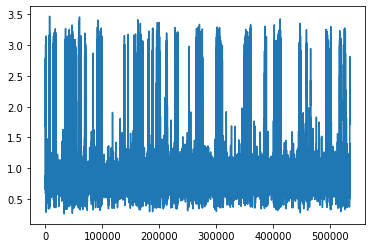

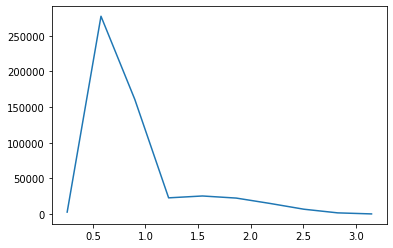

40000 427794
40008
40008 indx 40008


KeyboardInterrupt: 

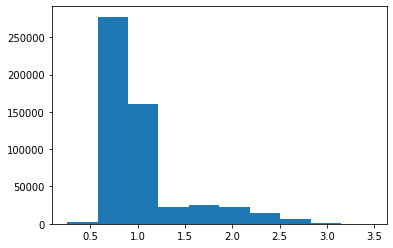

In [4]:
#Define bin sizes and number of observations to train on

bin_sizes = [1,5,10,25,50]
Dvec = [40000,20000,10000,1000] 

for Dv in Dvec:
    for b in bin_sizes:
        dim = 11
        trj_file = '../0A_aa_h2t/trj_%fns.xtc' %(b*0.2)
        pdb_file = '../0A_aa_h2t/trj_init%fns.pdb' %(b*0.2)

        # loading
        traj = md.load(trj_file, top=pdb_file)

        print(len(traj))

        npzfile = np.load('../0A_aa_h2t/princMom_%fns.npz' %(b*0.2)) 
        sorted(npzfile.files)
        princMom = npzfile['princMom']
        Rg = npzfile['Rg']

        print(princMom.shape)
        print(Rg.shape)
        npzfile = np.load('../0A_aa_h2t/h2t_%fns.npz' %(b*0.2)) 
        sorted(npzfile.files)
        h2t = npzfile['h2t_train']

        no = list(np.histogram(h2t,bins=10)[0])
        val = list(np.histogram(h2t,bins=10)[1][0:10])
        plt.plot(val,no)
        plt.show()
        plt.hist(h2t)

        indx = []
        j = 0
        # Training frames
        stopframe = Dv
        #Chose over first 80 percent of available traj
        totframe = int(round(len(h2t)*0.8))
        # number of pieces
        nohist = 10
        #train 10 percent on each ile
        ratio = 1/nohist
        print(stopframe,totframe)

        #find histogram values
        no = list(np.histogram(h2t[0:totframe],bins=nohist)[0])
        val = list(np.histogram(h2t[0:totframe],bins=nohist)[1][0:nohist])
        val.insert(0,0)

        #iterate over the number of histogram divisions
        for ile in range(nohist):
            #print(ile)
            # iterate over all frames
            for i in range(totframe):
                #iterate over deciles
                #print(stopframe*ratio*(ile+1))
                if j < stopframe*ratio*(ile+1):
                    # select that it is in the correct decile
                    if h2t[i] < val[ile+1] and h2t[i] > val[ile]:
                         for d in range(-dim+1,1):
                                if (i+d) not in indx:
                                    indx.append(i+d)
                                    j += 1
         
                elif j >= stopframe:
                    break
        #print how many frames we got
        print(j)
        traj_ss = deepcopy(traj[indx])
        princMom_ss = princMom[indx]
        Rg_ss = Rg[indx]
        h2t_ss = h2t[indx]

        print(len(h2t_ss), 'indx', len(indx))
        traj_ss_flip = deepcopy(traj_ss)
        for i in range(traj_ss_flip.n_frames):
            traj_ss_flip.xyz[i] = np.fliplr(np.flipud(traj_ss_flip.xyz[i]))
        traj_ss_mir = deepcopy(traj_ss)
        for i in range(traj_ss_mir.n_frames):
            xyz = deepcopy(traj_ss_mir.xyz[i])
            xyz[:,0] = -xyz[:,0]
            traj_ss_mir.xyz[i] = xyz

        N = traj_ss.n_frames #.n_frames
        P = np.zeros((N,N),dtype=float)
        for i in range(N-1):
            RMSD_i_normal = md.rmsd(traj_ss[i+1:],traj_ss[i],frame=0)
            #only for fliped symmetry
            #RMSD_i_flip = md.rmsd(traj_ss_flip[i+1:],traj_ss[i],frame=0)
            RMSD_i_mir = md.rmsd(traj_ss_mir[i+1:],traj_ss[i],frame=0)
            #RMSD_i = np.minimum(np.minimum(RMSD_i_normal,RMSD_i_flip),RMSD_i_mir)
            RMSD_i = np.minimum(RMSD_i_normal,RMSD_i_mir)
            P[i,i+1:] = RMSD_i
        P = P + P.T
        print(P.shape)
        outfile='P_%dk_%fns.npz' %(Dv,b*0.2)
        np.savez(outfile, P=P)

        # SELECT APPROPRIATE EPS VALUE
        eps = np.exp(-3)

        P = np.exp(-P**2/(2*eps))
        D = np.sum(P,axis=1)
        P = np.matmul(np.matmul(np.diag(D**(-0.5)),P),np.diag(D**(-0.5))) # constructing Ms as symmetric matrix for diagonalization

        nEvals=20
        lamb, psi = eigh(P,eigvals=(P.shape[0]-nEvals,P.shape[0]-1)) # scipy eigh to specify only computation of leading evals
        psi = np.matmul(np.diag(D**(-0.5)),psi) # converting evecs of Ms to evecs of M; M and Ms share evals
        idx_sort = np.flip(np.argsort(lamb))
        lamb = lamb[idx_sort]
        psi = psi[:,idx_sort]

        # plotting eval spectrum
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.bar(np.arange(1,len(lamb)), lamb[1:])
        ax.set_xlabel('eval idx')
        ax.set_ylabel('eval')
        plt.xticks(np.arange(1, len(lamb), step=1),fontsize=10)
        plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],fontsize=10)

        if showPlots:
            plt.draw()
            plt.show()
        fig.savefig('evals_%dk_%fns.png' %(Dv,b*0.2), dpi=300)
        plt.close()

        # plotting embedding

        plot_stride = 100
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(psi[::plot_stride,1], psi[::plot_stride,2])#, c=colorMap)
        ax.set_xlabel('psi_2')
        ax.set_ylabel('psi_3')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.xlim([np.min(psi[:,1])*1.1,np.max(psi[:,1])*1.1])
        plt.ylim([np.min(psi[:,2])*1.1,np.max(psi[:,2])*1.1])
        if showPlots:
            plt.draw()
            plt.show()
        fig.savefig('evecs_%dk_%fns.png' %(Dv,b*0.2), dpi=300, fontsize=15)
        plt.close()

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(psi[::plot_stride,1], psi[::plot_stride,2], psi[::plot_stride,3])#, c=colorMap)
        ax.set_xlabel('psi_2')
        ax.set_ylabel('psi_3')
        ax.set_zlabel('psi_4')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        if showPlots:
            plt.draw()
            plt.show()
        fig.savefig('evecs_234_%dk_%fns.png' %(Dv,b*0.2), dpi=300, fontsize=15)
        plt.close()

        # Nystrom extension applied to all frames in data set

        z = []

        start = time.time()

        print('Commencing Nystrom extension...')
        for i in range(traj.n_frames):
            RMSD_i_normal = md.rmsd(traj_ss,traj[i],frame=0)
            #RMSD_i_flip = md.rmsd(traj_ss_flip,traj[i],frame=0)
            RMSD_i_mir = md.rmsd(traj_ss_mir,traj[i],frame=0)
            RMSD_i = np.minimum(RMSD_i_normal,RMSD_i_mir)

            RMSD_i = np.exp(-RMSD_i**2/(2*eps))

            RMSD_i /= np.sum(RMSD_i)

            psi_Nystrom = np.divide( np.matmul(RMSD_i,psi), lamb)

            z.append(psi_Nystrom)

            if np.mod(i+1,5000) == 0:
                print('\tNystromed %d of %d frames...' % (i+1,traj.n_frames))

        z = np.array(z)
        z = z.reshape(z.shape[0],-1)

        print('DONE!')
        print('')

        end = time.time()
        print("Elapsed time %.2f (s)" % (end - start))

        np.savez('data_%dk_%fns.npz' %(Dv,b*0.2), z=z)
        print('Finished run %dk %fns' %(Dv, b*0.2))

In [34]:
def plot_reconstr_2(i,j,plot_stride):
    
    '''
    i - index of z_Takens to use for x-axis
    j - index of z_aa and z_aa_pred to use for y-axis
    plot_stride - frame skipper
    '''
    
    ax = plt.subplot(111)
    ax.scatter(z[::plot_stride,i], z[::plot_stride,j], c='r', marker='o')
    ax.scatter(z_org[::plot_stride,i], z_org[::plot_stride,j], c='b', marker='x')
    
    xmin = np.min( z[::plot_stride,i] )
    xmax = np.max( z[::plot_stride,i] )
    ymin = np.min( [ np.min(z_org[::plot_stride,j]), np.min(z[::plot_stride,j]) ] )
    ymax = np.max( [ np.max(z_org[::plot_stride,j]), np.max(z[::plot_stride,j]) ] )
    
    plt.xlim(xmin*1.1,xmax*1.1)
    plt.ylim(ymin*1.1,ymax*1.1)

    ax.set_xlabel('z_' + str(i))
    ax.set_ylabel('z_org_' + str(j) + ' OR z_' + str(j))
    
    ax.legend(['z_org_' + str(j), 'z_' + str(j)])
    
    fig = plt.gcf()
    fig.savefig('z_' + str(i) + '_VS_z_org_' + str(j) + '.png', dpi=300)
    if showPlots:
        plt.draw()
        plt.show()
    plt.close()



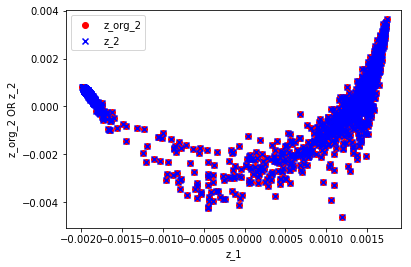

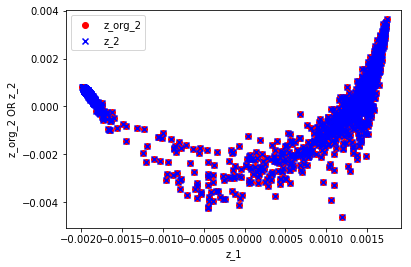

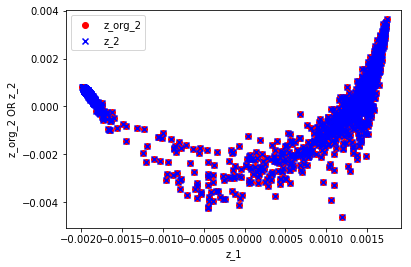

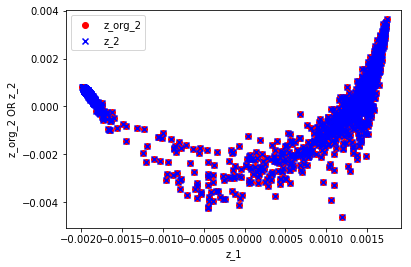

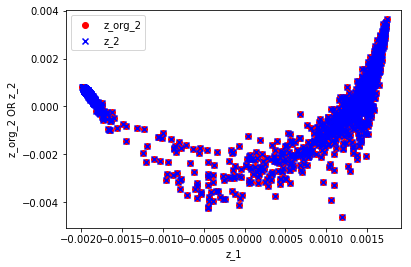

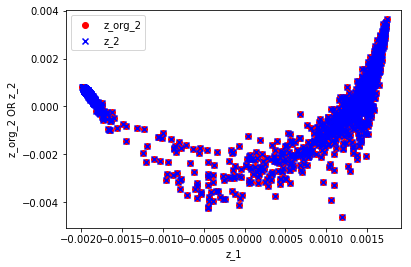

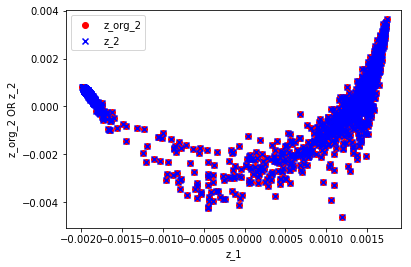

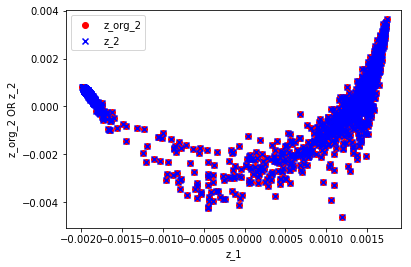

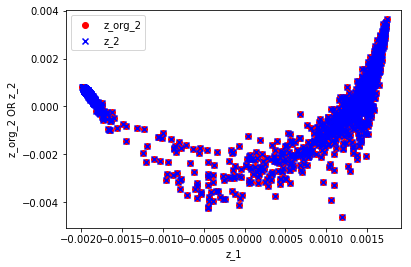

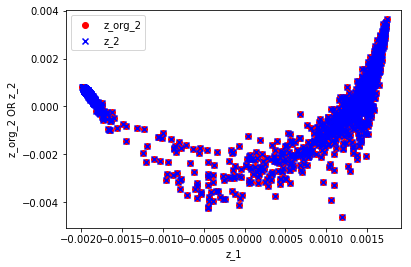

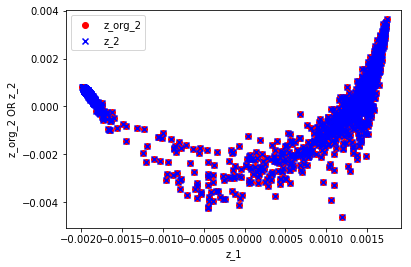

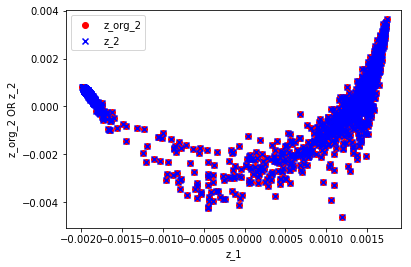

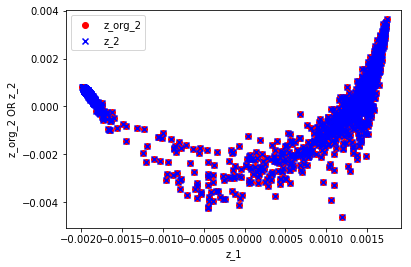

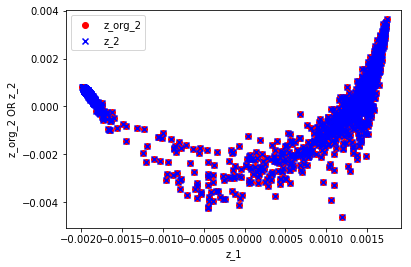

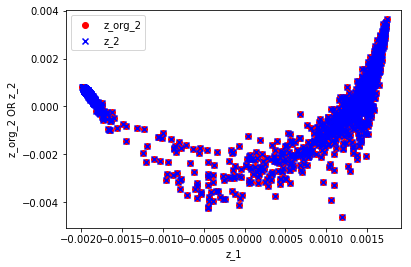

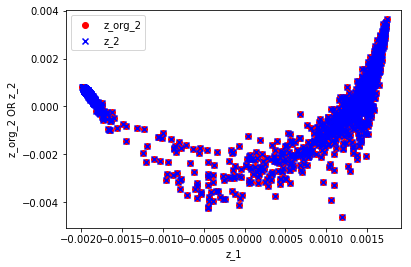

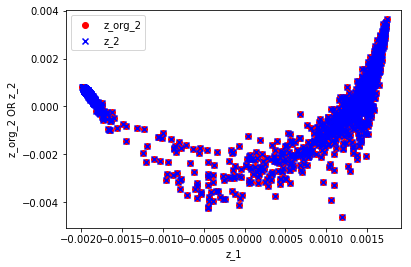

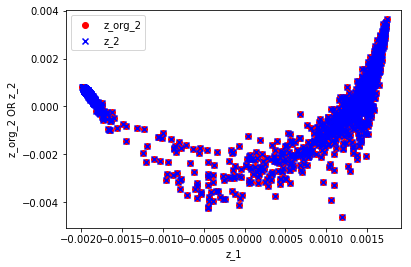

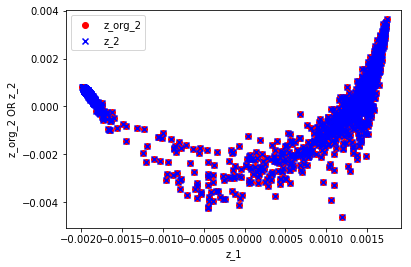

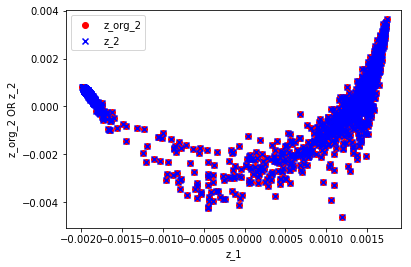

In [36]:
plot_stride = 100
bin_sizes = [1]
Dvec = [40000] 

#bin_sizes = [1]
#Dvec = [40000] 
for Dv in Dvec:
    for b in bin_sizes:
        z_org = np.load('data_%dk_%fns.npz' %(Dv,b*0.2))
        z_org = npzfile['z']

bin_sizes = [1,5,10,25,50]
Dvec = [40000,20000,10000,1000] 
for Dv in Dvec:
    for b in bin_sizes:
        z = np.load('data_%dk_%fns.npz' %(Dv,b*0.2))
        z = npzfile['z']
        #for i in range(z.shape[1]):
         #   for j in range(z_org.shape[1]):
        #for i in range(1,3):
         #   for j in range(1,3):
        plot_reconstr_2(1,2,plot_stride)
                